# import libraries

In [1]:
#OS libs
import os
import itertools

In [2]:
#Data handling tools
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

In [3]:
#Deep learning libs
import tensorflow as tf
from keras import Model
from keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPooling2D, Dense , Dropout , BatchNormalization, GlobalAveragePooling2D, Layer, Input, Flatten, Reshape, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.optimizers import Adam
from keras.applications import MobileNet

In [4]:
#Warningds
import warnings
warnings.filterwarnings('ignore')

# load data

In [5]:
train_data_path = 'data\Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [6]:
train_df

,filepaths,label
0,data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5195,data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5196,data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5197,data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5198,data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [7]:
test_data_path = 'data\Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [8]:
test_df

,filepaths,label
0,data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1195,data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1196,data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1197,data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1198,data\Testing\pituitary\Te-pi_0298.jpg,pituitary


# Split Test Data into Valid and Test

In [9]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

In [10]:
# Define image size and batch size
img_size = (256, 256)
batch_size = 16

# Create ImageDataGenerator instances for training, validation, and testing
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Create data generators for training, validation, and testing
train_gen = tr_gen.flow_from_dataframe(train_df, 
                                        x_col='filepaths', 
                                        y_col='label', 
                                        target_size = img_size,
                                        class_mode = 'categorical',
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid, 
                                        x_col = 'filepaths', 
                                        y_col=  'label', 
                                        target_size = img_size, 
                                        class_modeb = 'categorical',
                                        color_mode = 'rgb', 
                                        shuffle = True, 
                                        batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test, 
                                        x_col = 'filepaths', 
                                        y_col = 'label', 
                                        target_size = img_size, 
                                        class_mode = 'categorical', 
                                        color_mode = 'rgb', 
                                        shuffle = False, 
                                        batch_size = batch_size)


Found 5200 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.


# Show sample from train data

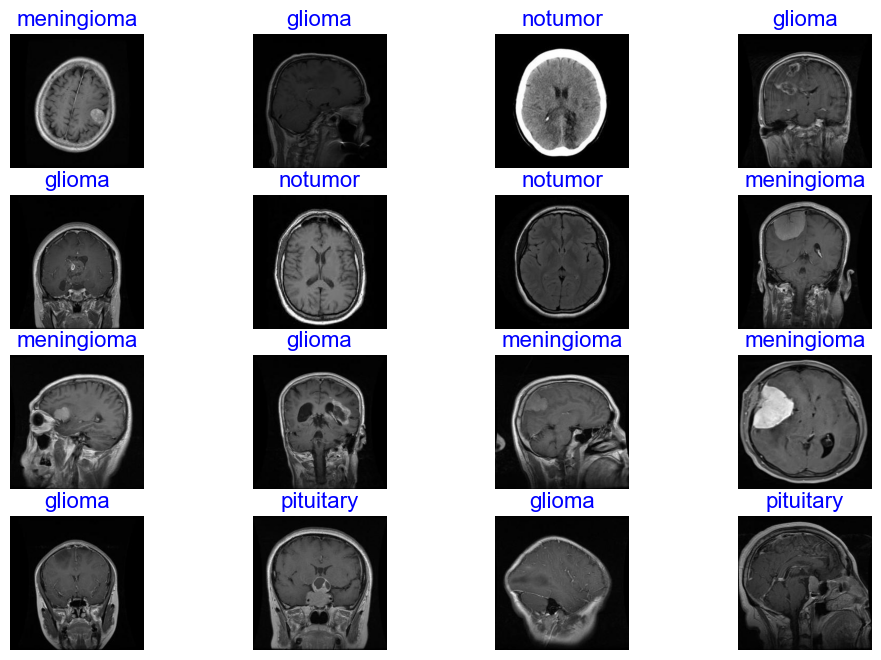

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (12,8))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 16)
    plt.axis('off')
plt.show()

In [12]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

# Model Structure

In [13]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

# SE Block with CNN and Mobilenet

In [15]:
from keras.layers import Layer, GlobalAveragePooling2D, Dense, Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Concatenate
from keras.models import Model, Sequential
from keras.applications import MobileNet
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
import tensorflow as tf

img_shape = (256, 256, 3)
num_class = len(classes)

class SEBlock(Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        super(SEBlock, self).build(input_shape)
        channels = input_shape[-1]
        self.global_pooling = GlobalAveragePooling2D()
        self.dense1 = Dense(channels // self.ratio, activation='relu')
        self.dense2 = Dense(channels, activation='sigmoid')

    def call(self, inputs):
        se = self.global_pooling(inputs)
        se = K.expand_dims(K.expand_dims(se, axis=1), axis=1)  # Expand dimensions to match input shape
        se = self.dense1(se)
        se = self.dense2(se)
        
        # Scale the input features
        return inputs * se

    def compute_output_shape(self, input_shape):
        return input_shape

# Define the CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        SEBlock(),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        SEBlock(),

        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        
        Dense(512, kernel_regularizer = regularizers.l2(l = 0.016), activation = 'relu'),
        Dropout(rate = 0.25, seed = 75),
        Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activation='relu'),
        Dropout(rate=0.25, seed=75),
    ])
    return model

# Create the CNN model and get the output shape
cnn_model = create_cnn_model(img_shape)

# Define the MobileNet model
def create_mobilenet_model(input_shape):
    base_model = MobileNet(weights='imagenet', include_top = False, input_shape = input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Create MobileNet model to extract features
mobilenet_model = create_mobilenet_model(img_shape, num_class)

# Define the combined model
combined_input = Input(shape=img_shape)
cnn_output = cnn_model(combined_input)
mobilenet_output = mobilenet_model(combined_input)

# Concatenate the outputs of both models
combined_features = Concatenate()([cnn_output, mobilenet_output])

# Add final classification layers
x = Dense(512, activation='relu')(combined_features)
x = Dropout(rate=0.2)(x)
predictions = Dense(num_class, activation='softmax')(x)

model = Model(inputs=combined_input, outputs=predictions)

# Compile the combined model
optimizer = Adam(learning_rate = 0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = METRICS)

# Display the combined model summary
model.summary()

TypeError: create_mobilenet_model() takes 1 positional argument but 2 were given

In [19]:
Epochs = 50
history = model.fit(train_gen, epochs = Epochs, verbose = 1, validation_data = valid_gen,
                    validation_steps = None, shuffle = False)

model.save("complete_model.h5")
model.save_weights("model_weights.h5")

Epoch 1/50
325/325 [==============================] - 1231s 4s/step - loss: 21.4488 - accuracy: 0.8924 - precision: 0.8199 - recall: 0.7300 - auc: 0.9438 - f1_score: 0.7650 - val_loss: 20.3263 - val_accuracy: 0.9367 - val_precision: 0.9073 - val_recall: 0.8317 - val_auc: 0.9800 - val_f1_score: 0.8673
Epoch 2/50
325/325 [==============================] - 1219s 4s/step - loss: 19.2781 - accuracy: 0.9550 - precision: 0.9207 - recall: 0.8973 - auc: 0.9876 - f1_score: 0.9084 - val_loss: 18.2716 - val_accuracy: 0.9563 - val_precision: 0.9202 - val_recall: 0.9033 - val_auc: 0.9918 - val_f1_score: 0.9111
Epoch 3/50
325/325 [==============================] - 1152s 4s/step - loss: 17.2781 - accuracy: 0.9725 - precision: 0.9502 - recall: 0.9390 - auc: 0.9948 - f1_score: 0.9444 - val_loss: 16.3355 - val_accuracy: 0.9679 - val_precision: 0.9410 - val_recall: 0.9300 - val_auc: 0.9951 - val_f1_score: 0.9344
Epoch 4/50
325/325 [==============================] - 1198s 4s/step - loss: 15.3803 - accuracy

# Performace

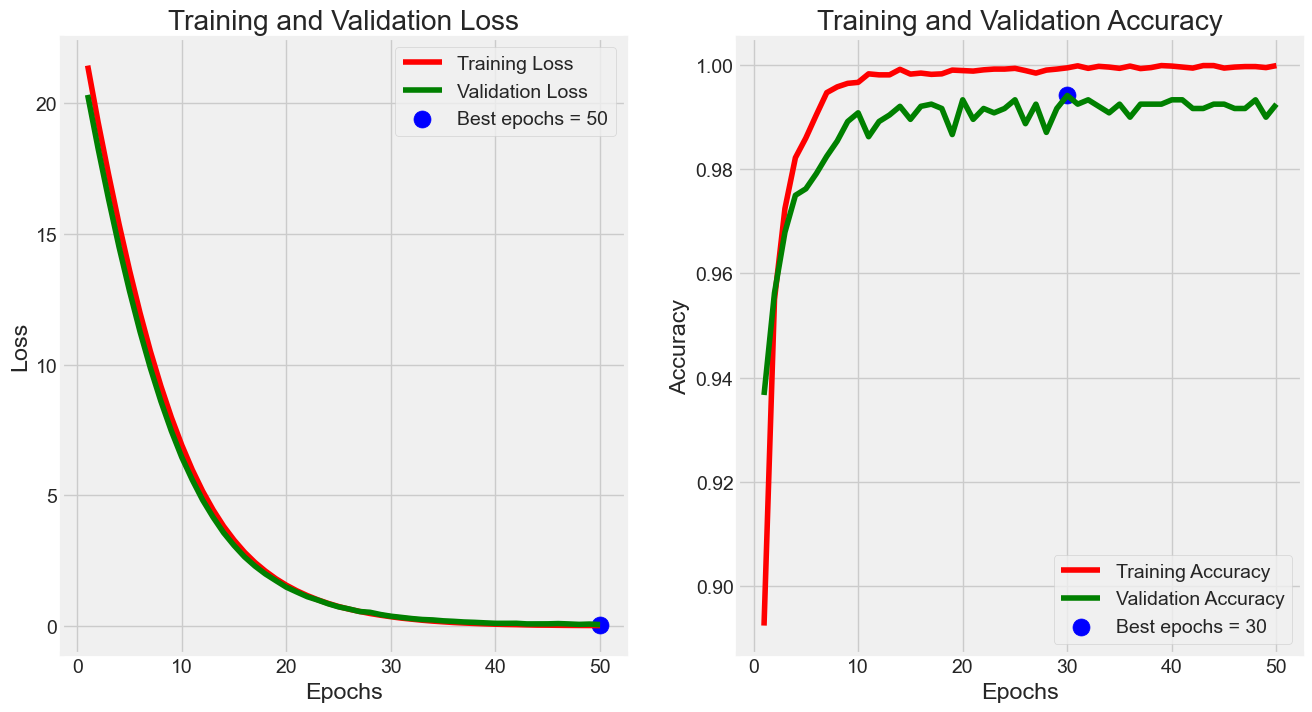

In [20]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (16,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# Evaluation

In [21]:
test_loss = model.evaluate(test_gen)
print("Test Loss:", test_loss)

38/38 [==============================] - 24s 625ms/step - loss: 0.0679 - accuracy: 0.9904 - precision: 0.9816 - recall: 0.9800 - auc: 0.9985 - f1_score: 0.9810
Test Loss: [0.06791584938764572, 0.9904166460037231, 0.9816360473632812, 0.9800000190734863, 0.9985283017158508, 0.9810059070587158]


In [22]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 11s 657ms/step - loss: 0.0215 - accuracy: 0.9961 - precision: 0.9922 - recall: 0.9922 - auc: 1.0000 - f1_score: 0.9922
Train Loss:  0.008539208211004734
Train Accuracy:  1.0
--------------------
Validation Loss:  0.06899658590555191
Validation Accuracy:  0.990234375
--------------------
Test Loss:  0.021501515060663223
Test Accuracy:  0.99609375


# Predection

In [23]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

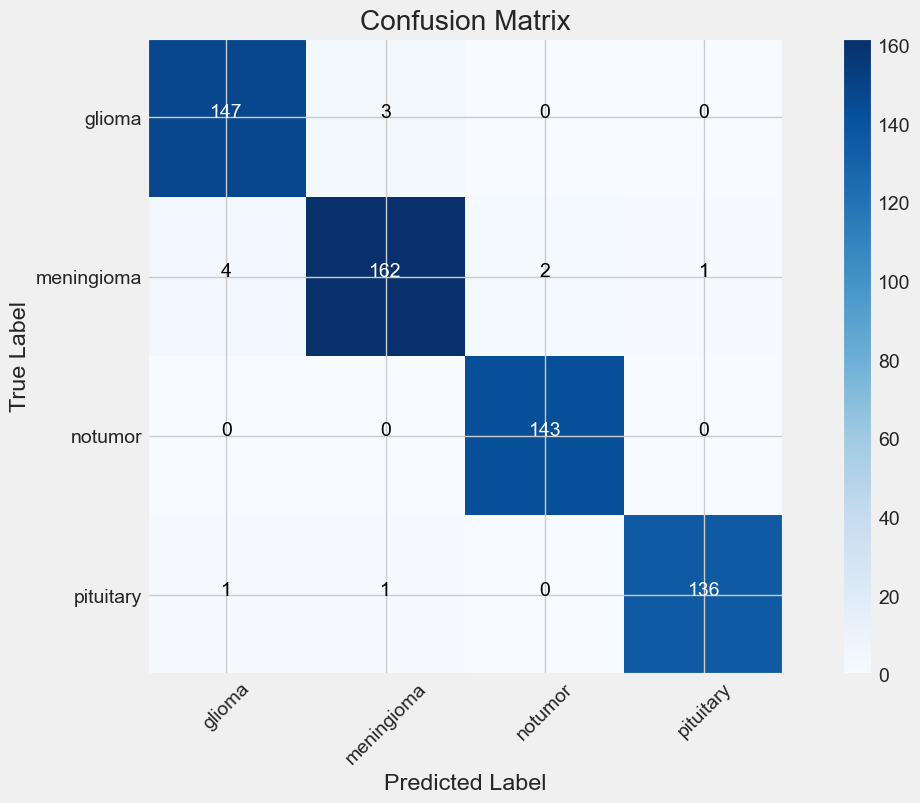

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (12, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [25]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.97      0.98      0.97       150
  meningioma       0.98      0.96      0.97       169
     notumor       0.99      1.00      0.99       143
   pituitary       0.99      0.99      0.99       138

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



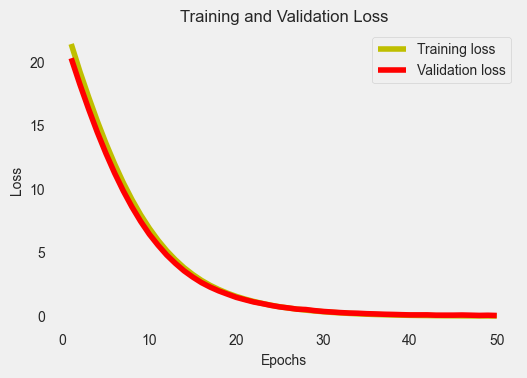

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()